In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
#### Import packages
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shap
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# show plots in jupyter notebook
%matplotlib inline
# set plot style
sns.set(color_codes = True)
# set minimum number of columns to be displayed
pd.set_option('display.max_columns', 100)
# load JS visualization code to nodebook
shap.initjs()

In [3]:
## Data directory
DATA_DIR = os.path.join('..', 'BCG', 'processed_data')
TRAINING_DATA = os.path.join(DATA_DIR, 'train_data.pkl')
HISTORY_DATA = os.path.join(DATA_DIR, 'history_data.pkl')


In [4]:
## Load data into a dataframe
train_data = pd.read_pickle(TRAINING_DATA)
history_data = pd.read_pickle(HISTORY_DATA)
## Merge data
train = pd.merge(train_data, history_data, on = 'id')


In [5]:
train.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'pow_max', 'churn', 'tenure', 'months_activ',
       'months_to_end', 'months_modif_prod', 'months_renewal', 'channel_epu',
       'channel_ewp', 'channel_fix', 'channel_foo', 'channel_lmk',
       'channel_sdd', 'channel_usi', 'origin_ewx', 'origin_kam', 'origin_ldk',
       'origin_lxi', 'origin_usa', 'activity_apd', 'activity_ckf',
       'activity_clu', 'activity_cwo', 'activity_fmw', 'activity_kkk',
       'activity_kwu', 'activity_sfi', 'activity_wxe',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'me

# Churn prediction with XGboost
- 1 [Split dataset](#1)
     - [$wX = Y$](#1.1)
     - [Training](#1.2)
     - [Validation](#1.3)
- 2 [Modeling](#2)
     - [Xgboost](#2.1)
- 3 [Modeling Evalutaion](#3)
     - [Accuracy, Precision, Recall](#3.1)
     - [ROC-AUC](#3.2)
     - [Stratified K-fold validation](#3.3)
- 4 [Model Fineturning](#4)
     - [Random search with Cross Validation](#4.1)
- 5 [Understanding the model](#5)
     - [Feature Importance](#5.1)
     - [Partial Dependence](#5.2)
     - [SHAP](#5.3)

<a id = '1'></a>
## Splitting Data
First of all we will split the data into the variable that we are trying to predict y (churn) and those variables that we will use to predict churn X (the rest)

In [6]:
y = train['churn']
X = train.drop(labels = ['id', 'churn'], axis = 1)

Next we will split the data into training and validation data. The percentages of each test can be changed but a 75% - 25% is a good ratio. We also use a random state generator in order to split it randomly. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 18)

<a id='2'></a>
## Modelling

In [8]:
model = xgb.XGBClassifier(learning_rate = 0.1, 
                          max_depth = 6, 
                          n_estimators = 500, 
                          n_jobs = -1)
result = model.fit(X_train, y_train)

[14:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<a id = '3'></a>
## Modeling Evaluation
<a id = '3.1'></a>
### Accuracy, Precision, Recall
We are going to evaluate our Logistic Regression model on out test data (which we did not use for training) using the evaluation metrics of:
> Accuracy: The most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations

> Precision: The ratio of correctly predicted positive observations to the total predicted positive observations

> Recall (Sensitivity): The ratio of correctly predicted positive observations to the all observations in actual class

In [9]:
def evaluate(model_, X_test_, y_test_):
    '''
    Evaluate the accuracy, precision and recall of a model
    '''
    # Get the model predictions
    prediction_test_ = model_.predict(X_test_)
    # Print the evaluation metrics as pandas dataframe
    results = pd.DataFrame({'Accuracy': [metrics.accuracy_score(y_test_, prediction_test_)],
                           'Precision': [metrics.precision_score(y_test_, prediction_test_)],
                           'Recall': [metrics.recall_score(y_test_, prediction_test_)]})
    # For a more detailed report
    # print(metrics.classification_report(y_test_, prediction_test_))
    return results

In [10]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.906809,0.738095,0.149398


<a id = '3.2'></a>
### ROC-AUC
Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate against false positive rate. It shows the tradeoff between sensitivity and specificity.

In a nutshell, it tells how much model is capable of distinguishing between classes.

In [11]:
def calculate_roc_auc(model_, X_test_, y_test_):
    '''
    Evaluate the roc-auc score
    '''
    # Get the model predictions
    # Note that we using the prediction for the class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:, 1]
    # compute roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)
    # print the evaluation metrics as opandas dataframe
    score = pd.DataFrame({'ROC-AUC': [metrics.auc(fpr, tpr)]})
    return fpr, tpr, score

def plot_roc_auc(fpr, tpr):
    '''
    Plotmthe Receiver Operating Characteristic from a list
    of true positive rates and false positive rates
    '''
    # Initialize plot
    f, ax = plt.subplots(figsize = (14, 8))
    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 
            lw = 2,
            alpha = 0.3,
            label = 'AUC = %0.2f' % (roc_auc)
           )
    # Plot the random line
    plt.plot([0,1], [0, 1], 
             linestyle = '--',
            lw = 3,
            color = 'r',
            label = 'Random',
            alpha = 0.8)
    # Fine tune and show the plot
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title('ROC-AUC')
    ax.legend(loc = 'lower right')
    plt.show()

In [12]:
fpr, tpr, auc_score = calculate_roc_auc(model, X_test, y_test)

In [13]:
auc_score

,ROC-AUC
0,0.684365


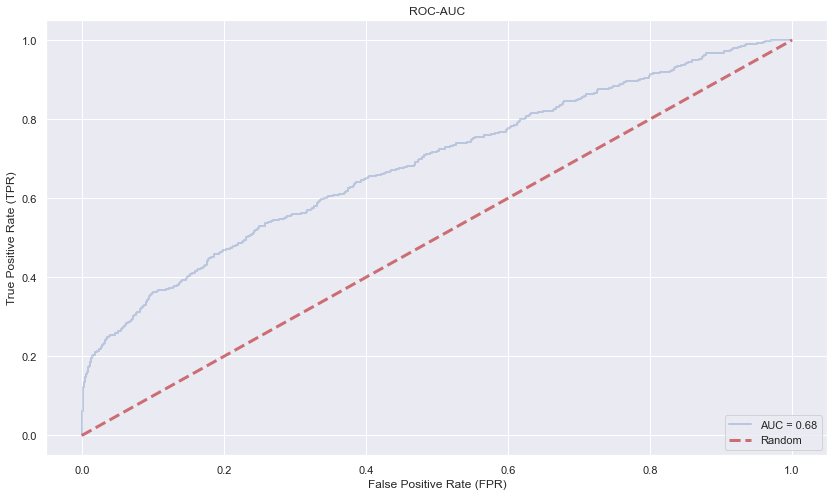

In [14]:
plot_roc_auc(fpr, tpr)
plt.show()

<a id='3.3'></a>
### Stratified K-fold validation

In [15]:
def plot_roc_curve(fprs, tprs):
    '''
    Plot the Receiver OOperating Characteristic from a list of true positive rates 
    and false positve rates.
    '''
    # Initialize useful lists + the plots axes
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize = (18, 10))
    
    # Plot ROC for each k-fold + comute AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, 
               lw = 2,
               alpha = 0.3,
               label = 'ROC fold %d (AUC = %0.2F)'%(i, roc_auc))
    # Plot the luck line
    plt.plot([0,1], [0,1], 
            linestyle = '--',
            lw = 3,
            color = 'r',
            label = 'Random',
            alpha = 0.8)
    # Plot the mean ROC
    mean_tpr = np.mean(tprs_interp, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, 
            color = 'b',
            label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw = 4,
           alpha = 0.8)
    # Plot the Standard deviation around the mean ROC
    std_tpr = np.std(tprs_interp, axis = 0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                   color = 'grey',
                   alpha = 0.2,
                   label = r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title('ROC-AUC')
    ax.legend(loc = 'lower right')
    plt.show()
    return (f, ax)

def compute_roc_auc(model_, index):
    y_predict = model_.predict_proba(X.iloc[index])[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

In [16]:
cv = StratifiedKFold(n_splits = 5, random_state = 13, shuffle = True)
fprs, tprs, scores = [], [], []


In [17]:
for (train, test), i in zip(cv.split(X,y), range(5)):
    model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model, train)
    fpr, tpr, auc_score = compute_roc_auc(model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    

[14:43:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

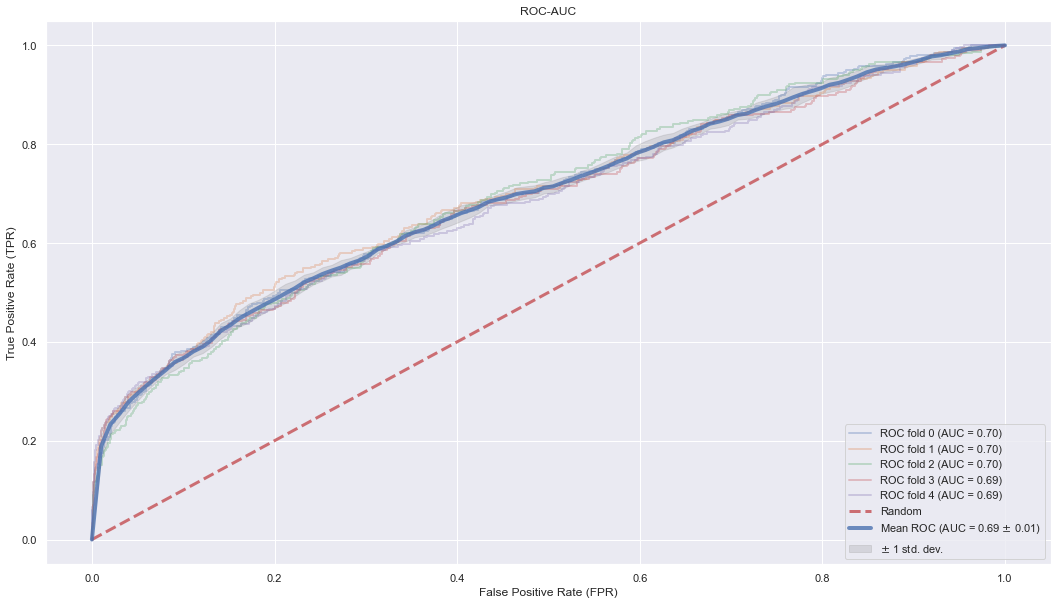

In [18]:
plot_roc_curve(fprs, tprs)
plt.show()

<a id='4'></a>
## Model Finetuning
<a id = '4.1'></a>
### Random Search Cross Validation

In [19]:
from sklearn.model_selection import RandomizedSearchCV


In [20]:
# Create the random grid
params = {
    'min_child_weight': [i for i in np.arange(1, 15, 1)],
    'gamma': [i for i in np.arange(0, 6, 0.5)],
    'subsample': [i for i in np.arange(0, 1.1, 0.1)],
    'colsample_bytree': [i for i in np.arange(0, 1.1, 0.1)],
    'max_depth': [i for i in np.arange(1, 15, 1)],
    'scale_pos_weight': [i for i in np.arange(1, 15, 1)],
    'learning_rate': [i for i in np.arange(0, 0.15, 0.01)],
    'n_estimators': [i for i in np.arange(0, 2000, 100)]
    
}

In [21]:
# create base model
xg = xgb.XGBClassifier(objective = 'binary:logistic',
                      silent = True,
                      nthread = 1)


In [22]:
# Random search of parameters, using 5
xg_random = RandomizedSearchCV(xg, param_distributions = params,
                              n_iter = 1,
                              scoring = 'roc_auc',
                              n_jobs = 4,
                              cv = 5,
                              verbose = 3,
                              random_state = 1001)
# Fit the random search model
xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.5s finished


[14:43:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [23]:
best_random = xg_random.best_params_
print(best_random)


{'subsample': 0.0, 'scale_pos_weight': 6, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 2.5, 'colsample_bytree': 1.0}


In [24]:
best_random = {'subsample': 0.8,
              'scale_pos_weight': 1,
              'n_estimators': 1100,
              'min_child_weight': 1,
              'max_depth': 12,
              'learning_rate': 0.01,
              'gamma': 4.0,
              'colsample_bytree': 0.60}

In [25]:
# create a model with the parameters found
model_random = xgb.XGBClassifier(objective = 'binary:logistic',
                                 silent = True,
                                 nthread = 1,
                                 **best_random)
fprs, tprs, scores = [],[],[]

In [26]:
for (train, test), i in zip(cv.split(X,y), range(5)):
    model_random.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_random, train)
    fpr, tpr, auc_score = compute_roc_auc(model_random, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

[14:43:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:45

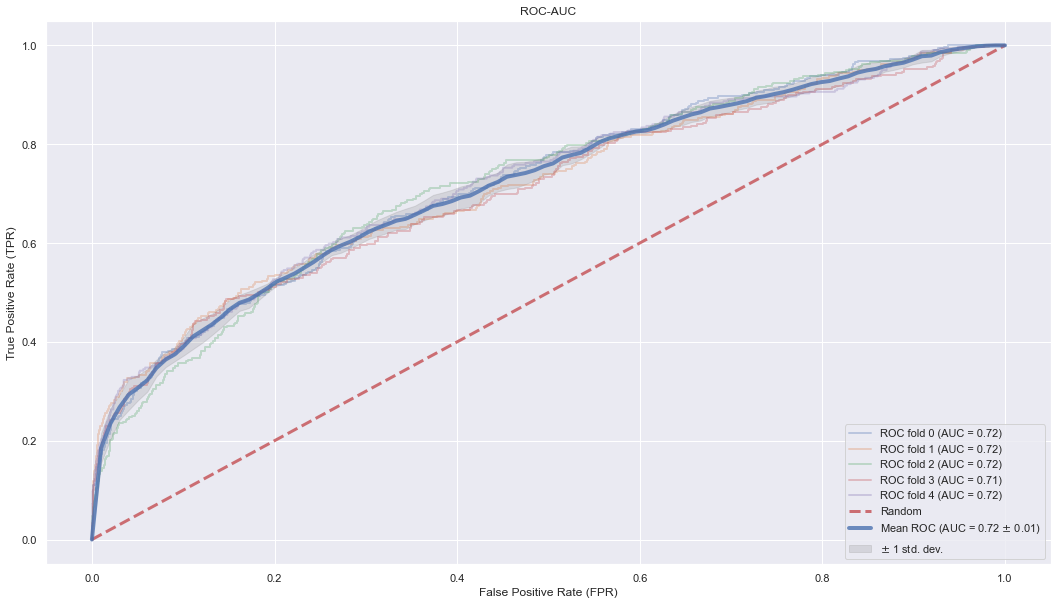

In [27]:
plot_roc_curve(fprs, tprs)
plt.show()

### Grid Search with Cross Validation 

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# Create the parameter grid based on the results of random search
param_grid = {
    'subsample': [0.7],
    'scale_pos_weight': [1],
    'n_estimators': [1100],
    'min_child_weight': [1],
    'max_depth': [12, 13, 14],
    'learning_rate': [0.005, 0.01],
    'gamma': [4.0],
    'colsample_bytree': [0.6]
}

In [30]:
# create model
xg = xgb.XGBClassifier(objective = 'binary:logistic',
                      nthread = 1, n_jobs = -1)


In [31]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg, 
                           param_grid = param_grid,
                           cv = 5,
                           verbose = 2,
                           scoring = 'roc_auc')

In [32]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7 
[14:49:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7, total=  54.4s
[CV] colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7 
[14:50:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7, total=  53.3s
[CV] colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7 
[14:51:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7, total=  52.2s
[CV] colsample_bytree=0.6, gamma=4.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=1100, scale_pos_weight=1, subsample=0.7 
[14:52:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0,

KeyboardInterrupt: 

In [ ]:
best_grid = grid_search.best_params_
best_grid

In [ ]:
# create a model with the parameters found
model_grid = xgb.XGBClassifier(objective = 'binary:logistic',
                               nthread = 1,
                               **best_grid)
fprs, tprs, scores = [], [], []

In [ ]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model_grid.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_grid, train)
    fpr, tpr, auc_score = compute_roc_auc(model_grid, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    

In [ ]:
plot_roc_curve(fprs, tprs)
plt.show


<a id='5'></a>
## Understanding the model
<a id = '5.1'></a>
### Feature Importance
One simple way of observing the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.

In [ ]:
fig, ax = plt.subplots(figsize = (15, 20))
xgb.plot_importance(model_grid, ax=ax);

In the feature importance graph above we can see that `cons_12m` and `net_margin` are the features that appear the most in our model and we could infer that these two features have a significant importance in our model.


<a id='5.2'></a>
### Partial Dependence Plot

In [ ]:
from sklearn.inspection import plot_partial_dependence


Because currently there is a bug that does not allow us to use our trained model with oandas dataframes, we will areplica and train it using numpy arrays

In [ ]:
# create a model with the parameters found
model_grid_v2 = xgb.XGBClassifier(objective = 'binary:logistic',
                                 nthread = 1,
                                 **best_grid)
model_grid_v2.fit(X_train.values, y_train.values)

In [ ]:
fig = plt.figure(figsize = (15, 15))
plot_partial_dependence(model_grid_v2, X_test.values,
                       features = [16, 49],
                       feature_names = X_test.columns.tolist(),
                       fig = fig);

### Save the test data

In [ ]:
# save the test data
y_test_pred = model_grid.predict_proba(X_test)


X_test['y_test_pred'] = y_test_pred.T[1]
X_test['y_test'] = y_test

X_test.head()

In [ ]:
pickle_train_dir = os.path.join('../BCG', 'processed_data', 'xgb_outOfSamplePredictions.pkl')
pd.to_pickle(X_test, pickle_train_dir)

In [ ]:
X_test.drop(columns = ['y_test', 'y_test_pred'], inplace = True)

Comparing the PDP plots with respect to our previous models, we can see how they are slightly different. `tenure`<br>

The overall trend is unchanged as compared to our previoous models, we cansee how they are slighly different times of the tenure (6y) but then it goes down again and bottoms around 10 years. Then, it starts recovering a bit.

`mean_year_price_p2` <br>

In our previous models, we saw a sort of 'stairshape', in this case we see the PDP is almost flat with some spikes on the extreme values, whcih hints us that the variable `mean_year_price_p2` is not very relevant in this model.

<a id='5.3'></a>
### SHAP - Feature Importance


In [ ]:
explainer = shap.TreeExplainer(model_grid)
shap_values = explainer.shap_values(X_test)

In [ ]:
# Feature importance for class 1 - churn
shap.summary_plot(shap_values, 
                  X_test, 
                  plot_type = 'bar')

As expeced the `margin_net_pow_ele` is most important feature by far. It is interesting to compare how much important the top feature becomes in contrast with the other models we created `Randon forest` and `Logistic Regression`


### SHAP - Partial Dependence Plot


In [ ]:

shap.dependence_plot('tenure', shap_values, X_test) #, interaction_index = 'origin_lxi

In this case we see a much clearer pattern, in which the longer the tenure the less likely the company is, sort of decreasing linearly until it bottoms around 9y of tenure. From year 10 of tenure, the churn increases again.

In [ ]:
shap.force_plot(explainer.expected_value, 
                shap_values[4023], 
                X_test.iloc[4023, :], 
                link = 'logit')

In [ ]:
shap.summary_plot(shap_values, X_test);